### Multi-GPU doesn't work... nvidia-smi still shows only one GPU with memory use

In [5]:
%load_ext autoreload
%autoreload 2

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"
import sys
sys.path.append("/home/jiahuikchen/BAGEL")
from copy import deepcopy
from typing import (
    Any,
    AsyncIterable,
    Callable,
    Dict,
    Generator,
    List,
    NamedTuple,
    Optional,
    Tuple,
    Union,
)
import requests
from io import BytesIO

from PIL import Image
import torch
from accelerate import infer_auto_device_map, load_checkpoint_and_dispatch, init_empty_weights

from data.transforms import ImageTransform
from data.data_utils import pil_img2rgb, add_special_tokens
from modeling.bagel import (
    BagelConfig, Bagel, Qwen2Config, Qwen2ForCausalLM, SiglipVisionConfig, SiglipVisionModel
)
from modeling.qwen2 import Qwen2Tokenizer
from modeling.bagel.qwen2_navit import NaiveCache
from modeling.autoencoder import load_ae
from safetensors.torch import load_file

from huggingface_hub import snapshot_download


model_path = "/checkpoint/dream_v2/transfusion/BAGEL-7B-MoT"

# LLM config preparing
llm_config = Qwen2Config.from_json_file(os.path.join(model_path, "llm_config.json"))
llm_config.qk_norm = True
llm_config.tie_word_embeddings = False
llm_config.layer_module = "Qwen2MoTDecoderLayer"

# ViT config preparing
vit_config = SiglipVisionConfig.from_json_file(os.path.join(model_path, "vit_config.json"))
vit_config.rope = False
vit_config.num_hidden_layers = vit_config.num_hidden_layers - 1

# VAE loading
vae_model, vae_config = load_ae(local_path=os.path.join(model_path, "ae.safetensors"))

# Bagel config preparing
config = BagelConfig(
    visual_gen=True,
    visual_und=True,
    llm_config=llm_config, 
    vit_config=vit_config,
    vae_config=vae_config,
    vit_max_num_patch_per_side=70,
    connector_act='gelu_pytorch_tanh',
    latent_patch_size=2,
    max_latent_size=64,
)

with init_empty_weights():
    language_model = Qwen2ForCausalLM(llm_config)
    vit_model      = SiglipVisionModel(vit_config)
    model          = Bagel(language_model, vit_model, config)
    model.vit_model.vision_model.embeddings.convert_conv2d_to_linear(vit_config, meta=True)

# Tokenizer Preparing
tokenizer = Qwen2Tokenizer.from_pretrained(model_path)
tokenizer, new_token_ids, _ = add_special_tokens(tokenizer)

# Image Transform Preparing
vae_transform = ImageTransform(1024, 512, 16)
vit_transform = ImageTransform(980, 224, 14)

# --- Begin Multi-GPU Loading Section ---

max_mem_per_gpu = "79GiB"  # Leave some headroom for system
num_gpus = 8

device_map = infer_auto_device_map(
    model,
    max_memory={i: max_mem_per_gpu for i in range(num_gpus)},
    no_split_module_classes=["Bagel", "Qwen2MoTDecoderLayer"],
)

# Remove same_device_modules constraints to allow full distribution

model = load_checkpoint_and_dispatch(
    model,
    checkpoint=os.path.join(model_path, "ema.safetensors"),
    device_map=device_map,
    offload_buffers=False,
    dtype=torch.bfloat16,
    force_hooks=True,
    offload_folder="/tmp/offload"
)

# # Optional: print memory summary for verification
# print(torch.cuda.memory_summary(device=None, abbreviated=True))

model = model.eval()
print('Model loaded')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The safetensors archive passed at /checkpoint/dream_v2/transfusion/BAGEL-7B-MoT/ema.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.


Model loaded


In [6]:
from inferencer import InterleaveInferencer
import random
import numpy as np


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

inferencer = InterleaveInferencer(
    model=model, 
    vae_model=vae_model, 
    tokenizer=tokenizer, 
    vae_transform=vae_transform, 
    vit_transform=vit_transform, 
    new_token_ids=new_token_ids
)

# Image gen with think params 
t2i_think_params =dict(
    think=True,
    max_think_token_n=1000,
    do_sample=False,
    # text_temperature=0.3,
    cfg_text_scale=4.0,
    cfg_img_scale=1.0,
    cfg_interval=[0.4, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="global",
)

# Edit with think params
edit_think_params = dict(
    think=True,
    max_think_token_n=1000,
    do_sample=False,
    # text_temperature=0.3,
    cfg_text_scale=4.0,
    cfg_img_scale=2.0,
    cfg_interval=[0.0, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="text_channel",
)

A bottle of perfume to the left of a lipstick
----------


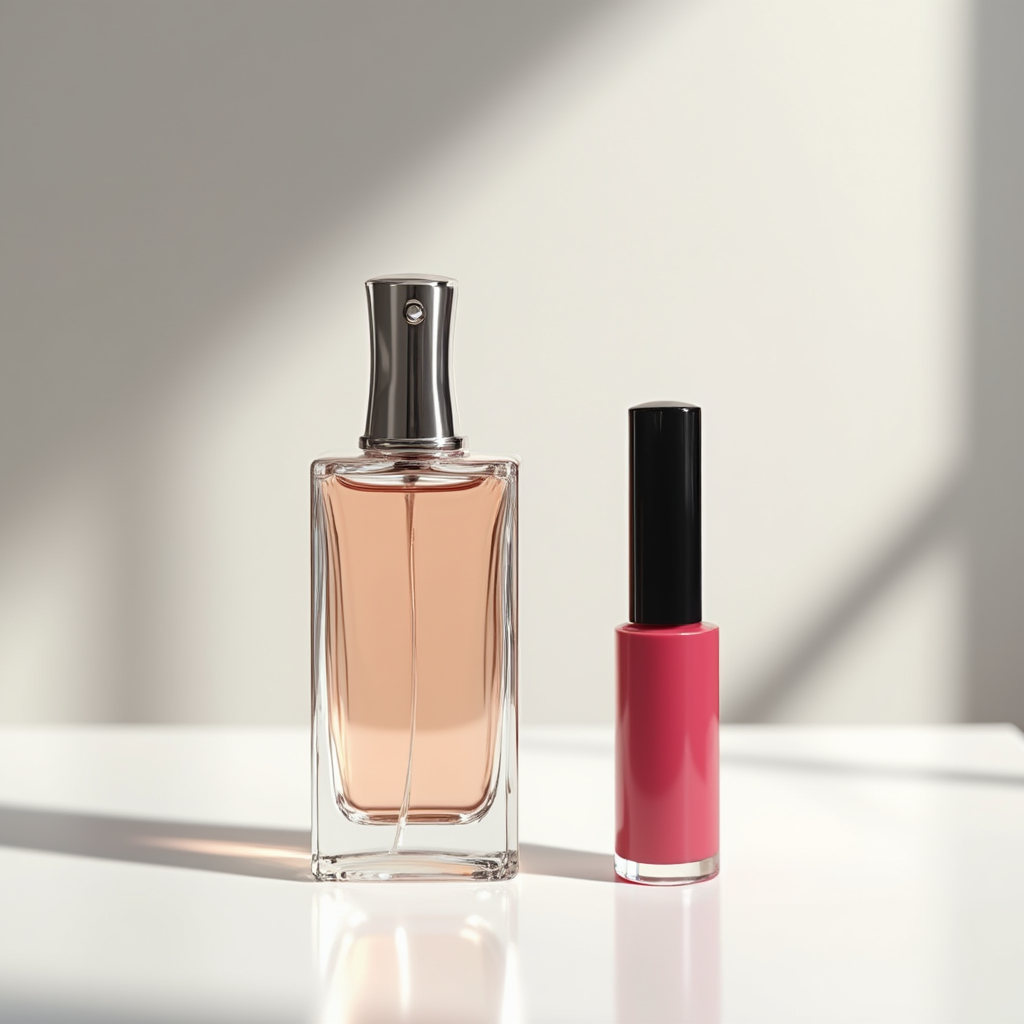

Thinking: <think>
The model should generate an image where the perfume bottle is positioned to the left of the lipstick, clearly showing their spatial arrangement.
The comprehensive prompt is: A highly detailed and realistic image of a perfume bottle positioned to the left of a lipstick, both objects clearly visible and well-lit. The perfume bottle is elegant and glass-like, with a slender neck and a sophisticated cap, while the lipstick is sleek and modern, with a vibrant color and smooth texture. The scene is set on a clean, neutral surface, such as a white countertop, with soft, natural lighting creating gentle shadows and highlights. The atmosphere is minimalistic and refined, emphasizing the objects' design and arrangement. The perspective is slightly angled to showcase both items distinctly, with no distractions in the background, ensuring the focus remains solely on the perfume bottle and lipstick.
</think>


In [ ]:
prompt = 'A bottle of perfume in front of nail polish'
print(prompt)
print('-' * 10)
output_dict = inferencer(text=prompt, **t2i_think_params)
display(output_dict['image'])
print(f"Thinking: {output_dict['text']}")

In [ ]:
prompt = 'Earrings on top of a pair of heels'
print(prompt)
print('-' * 10)
output_dict = inferencer(text=prompt, **t2i_think_params)
display(output_dict['image'])
print(f"Thinking: {output_dict['text']}")

Earrings on top of a pair of heels
----------


Clown fish swimming behind a sea anemone
----------


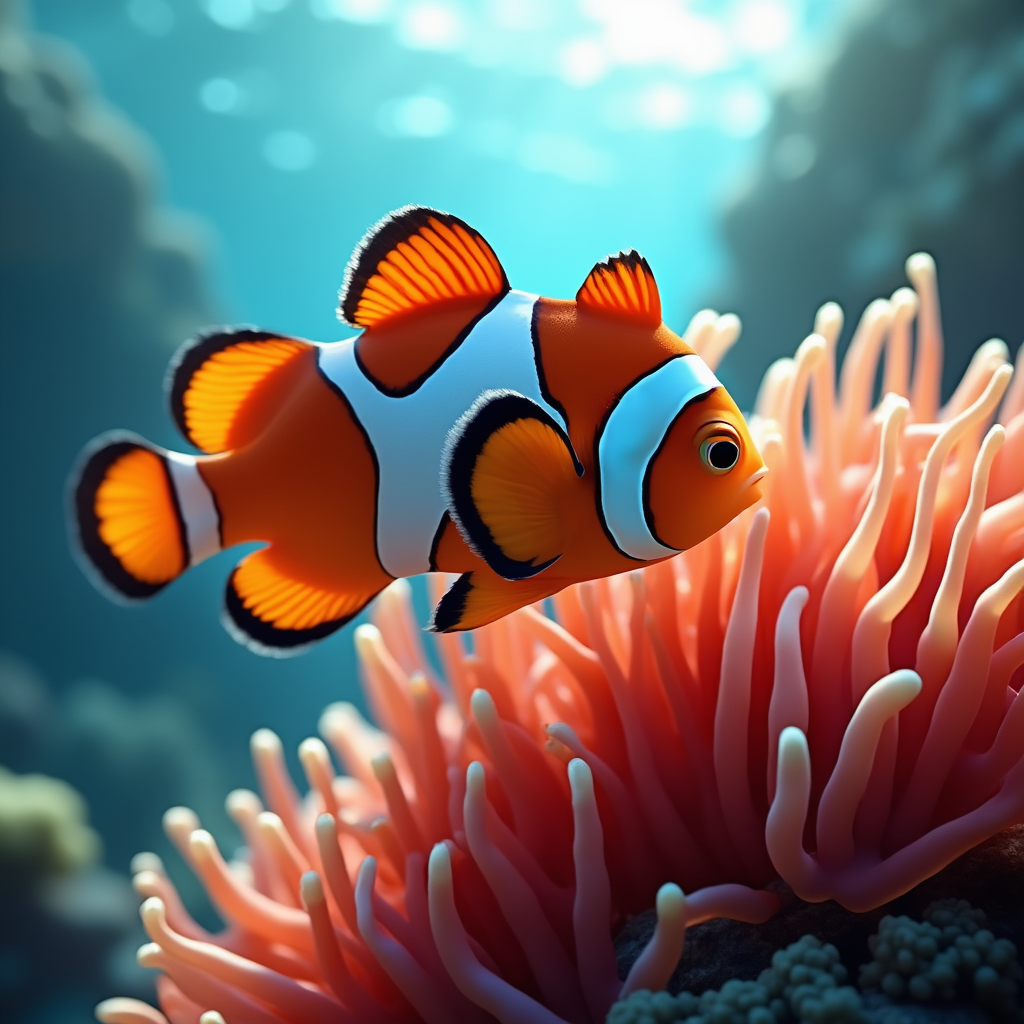

Thinking: <think>
The model should generate an image of a clown fish swimming near a sea anemone, with the anemone's tentacles visible in the background. The clown fish should be brightly colored with orange and white stripes, and the anemone should have vibrant red and white tentacles.
The complete, polished prompt is: A vibrant underwater scene featuring a brightly colored clown fish with striking orange and white stripes swimming gracefully near a sea anemone. The anemone's tentacles are vividly detailed, showcasing a mix of red and white hues, creating a dynamic and colorful contrast. The setting is illuminated by soft, natural sunlight filtering through the water, casting gentle rays and creating a serene, tranquil atmosphere. The image captures the intricate textures of the fish and anemone, with a shallow depth of field emphasizing the subjects while softly blurring the background, evoking a sense of depth and immersion in the ocean environment. Ultra-realistic rendering with ci

In [60]:
prompt = 'Clown fish swimming behind a sea anemone'
print(prompt)
print('-' * 10)
output_dict = inferencer(text=prompt, **t2i_think_params)
display(output_dict['image'])
print(f"Thinking: {output_dict['text']}")

A perfume bottle lying flat
----------


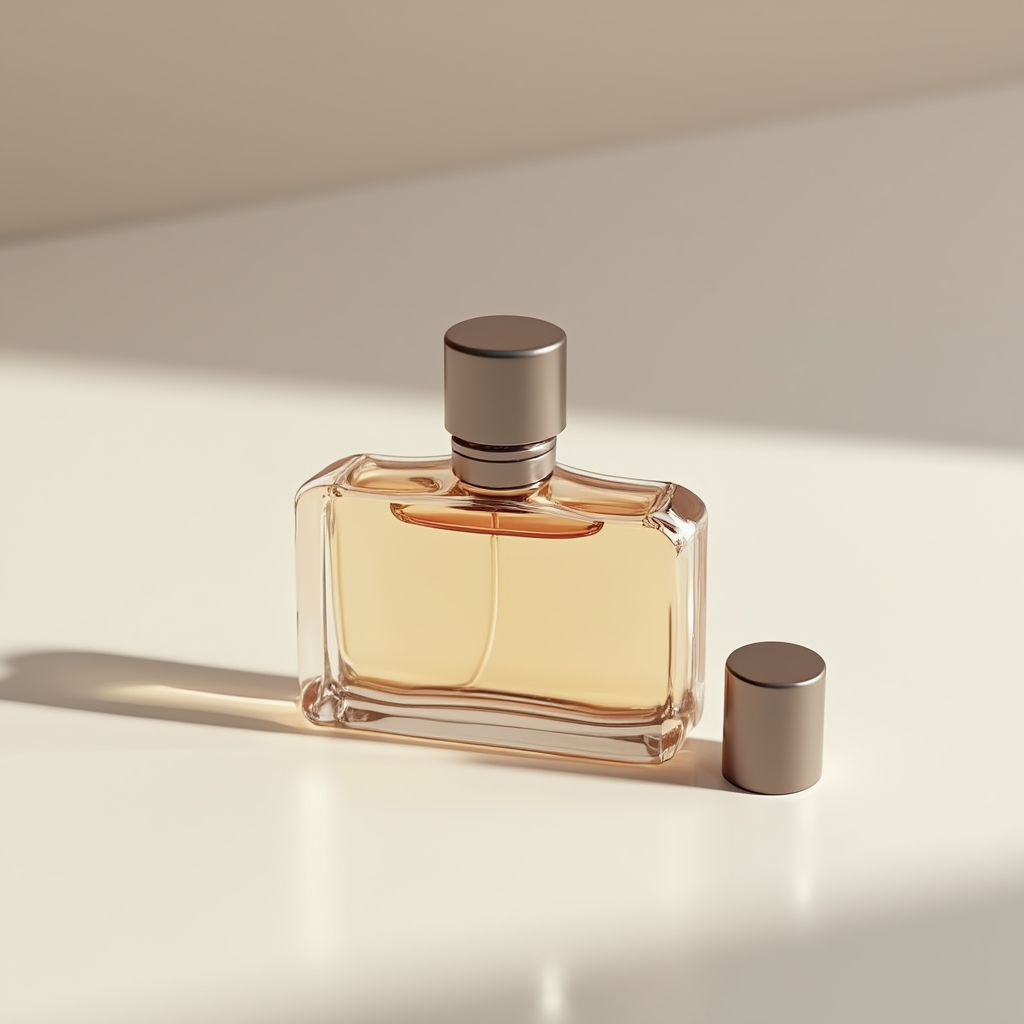

Thinking: <think>
The model should generate an image of a perfume bottle placed horizontally on a surface, with its cap removed and the bottle lying flat, showcasing the liquid inside.
The complete, polished prompt is: A sleek perfume bottle lying flat on a smooth, neutral-toned surface, its cap removed to reveal the liquid inside. The bottle is elegantly designed with a glossy finish, showcasing subtle reflections and a minimalist aesthetic. The liquid inside is clear and slightly tinted, with soft, natural lighting illuminating the scene to emphasize the bottle's contours and the liquid's transparency. The atmosphere is clean and sophisticated, with a focus on the simplicity and elegance of the composition, captured in ultra-realistic detail.
</think>


In [63]:
prompt = 'A perfume bottle lying flat'
print(prompt)
print('-' * 10)
output_dict = inferencer(text=prompt, **t2i_think_params)
display(output_dict['image'])
print(f"Thinking: {output_dict['text']}")

### Loading one BAGEL model on EACH GPU
(works despite the warnings)

In [3]:
%load_ext autoreload
%autoreload 2

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"
from copy import deepcopy
from typing import (
    Any,
    AsyncIterable,
    Callable,
    Dict,
    Generator,
    List,
    NamedTuple,
    Optional,
    Tuple,
    Union,
)
import requests
from io import BytesIO

from PIL import Image
import torch
from accelerate import infer_auto_device_map, load_checkpoint_and_dispatch, init_empty_weights

from data.transforms import ImageTransform
from data.data_utils import pil_img2rgb, add_special_tokens
from modeling.bagel import (
    BagelConfig, Bagel, Qwen2Config, Qwen2ForCausalLM, SiglipVisionConfig, SiglipVisionModel
)
from modeling.qwen2 import Qwen2Tokenizer
from modeling.bagel.qwen2_navit import NaiveCache
from modeling.autoencoder import load_ae
from safetensors.torch import load_file

from huggingface_hub import snapshot_download


model_path = "/checkpoint/dream_v2/transfusion/BAGEL-7B-MoT"

# LLM config preparing
llm_config = Qwen2Config.from_json_file(os.path.join(model_path, "llm_config.json"))
llm_config.qk_norm = True
llm_config.tie_word_embeddings = False
llm_config.layer_module = "Qwen2MoTDecoderLayer"

# ViT config preparing
vit_config = SiglipVisionConfig.from_json_file(os.path.join(model_path, "vit_config.json"))
vit_config.rope = False
vit_config.num_hidden_layers = vit_config.num_hidden_layers - 1

# Image Transform Preparing
vae_transform = ImageTransform(1024, 512, 16)
vit_transform = ImageTransform(980, 224, 14)

gpu_devices = ["cuda:0", "cuda:1", "cuda:2", "cuda:3", "cuda:4", "cuda:5", "cuda:6", "cuda:7"] 
# Initialize an empty list to store the loaded models
models = []
# Loop through each model path and GPU device
for gpu_device_i in range(len(gpu_devices)):
    gpu_device = gpu_devices[gpu_device_i]

    # VAE loading
    vae_model, vae_config = load_ae(local_path=os.path.join(model_path, "ae.safetensors"))

    # Tokenizer Preparing
    tokenizer = Qwen2Tokenizer.from_pretrained(model_path)
    tokenizer, new_token_ids, _ = add_special_tokens(tokenizer)

    # Create a new Bagel configuration
    config = BagelConfig(
        visual_gen=True,
        visual_und=True,
        llm_config=llm_config,
        vit_config=vit_config,
        vae_config=vae_config,
        vit_max_num_patch_per_side=70,
        connector_act='gelu_pytorch_tanh',
        latent_patch_size=2,
        max_latent_size=64,
    )
    # Initialize the model with empty weights
    with init_empty_weights():
        language_model = Qwen2ForCausalLM(llm_config)
        vit_model = SiglipVisionModel(vit_config)
        model = Bagel(language_model, vit_model, config)
        model.vit_model.vision_model.embeddings.convert_conv2d_to_linear(vit_config, meta=True)
    # Load the model weights
    device_map = infer_auto_device_map(
        model,
        max_memory={gpu_device_i: "80GiB"},
        no_split_module_classes=["Bagel", "Qwen2MoTDecoderLayer"],
    )
    model = load_checkpoint_and_dispatch(
        model,
        checkpoint=os.path.join(model_path, "ema.safetensors"),
        device_map=device_map,
        offload_buffers=True,
        dtype=torch.bfloat16,
        force_hooks=True,
        offload_folder="/tmp/offload"
    )
    # Move the model to the specified GPU device
    model.to(gpu_device)
    # Append the loaded model to the list
    models.append(model.eval())
print("Multiple models loaded")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The safetensors archive passed at /checkpoint/dream_v2/transfusion/BAGEL-7B-MoT/ema.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.
You shouldn't move a model that is dispatched using accelerate hooks.
The safetensors archive passed at /checkpoint/dream_v2/transfusion/BAGEL-7B-MoT/ema.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.
You shouldn't move a model that is dispatched using accelerate hooks.
The safetensors archive passed at /checkpoint/dream_v2/transfusion/BAGEL-7B-MoT/ema.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.
You shouldn't move a model that is dispatched using accelerate hooks.
The safetensors archive passed at /checkpoint/dream_v2/transfusion/BAGEL-7B-MoT/ema.safetensors does not contain metadata. Make sure to save y

Multiple models loaded


In [8]:
from inferencer import InterleaveInferencer
import random
import numpy as np


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

inferencers = []
for model in models:
    inferencer = InterleaveInferencer(
        model=model, 
        vae_model=vae_model, 
        tokenizer=tokenizer, 
        vae_transform=vae_transform, 
        vit_transform=vit_transform, 
        new_token_ids=new_token_ids
    )
    inferencers.append(inferencer)

# Image gen with think params 
t2i_think_params =dict(
    think=True,
    max_think_token_n=1000,
    do_sample=False,
    # text_temperature=0.3,
    cfg_text_scale=4.0,
    cfg_img_scale=1.0,
    cfg_interval=[0.4, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="global",
)

# Edit with think params
edit_think_params = dict(
    think=True,
    max_think_token_n=1000,
    do_sample=False,
    # text_temperature=0.3,
    cfg_text_scale=4.0,
    cfg_img_scale=2.0,
    cfg_interval=[0.0, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="text_channel",
)

A duck standing behind some reed
----------


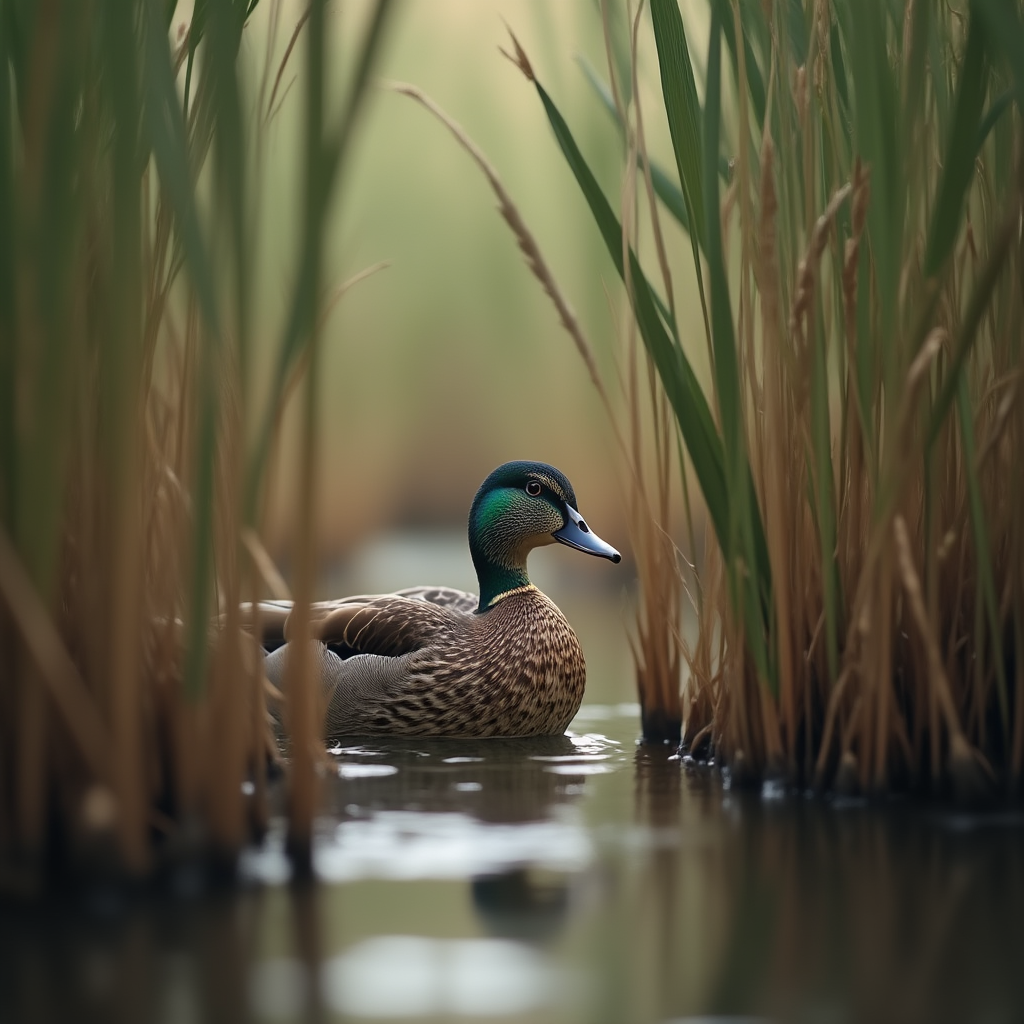

Thinking: <think>
The model should generate an image of a duck partially hidden behind tall reeds, demonstrating occlusion.
The complete, polished prompt is: A serene natural scene featuring a duck partially hidden behind tall, dense reeds, with the duck's body obscured by the foliage, showcasing a sense of natural occlusion. The setting is a tranquil wetland with soft, diffused lighting, emphasizing the peaceful atmosphere. The reeds are tall and slightly swaying, with subtle textures and earthy tones, while the duck's feathers are detailed and realistic, blending harmoniously with the environment. The perspective is slightly low and close, focusing on the interaction between the duck and the reeds, with a shallow depth of field creating a gentle bokeh effect in the background. The overall mood is calm and immersive, capturing the beauty of wildlife in its natural habitat.
</think>


In [9]:
prompt = 'A duck standing behind some reed'
print(prompt)
print('-' * 10)
output_dict = inferencers[0](text=prompt, **t2i_think_params)
display(output_dict['image'])
print(f"Thinking: {output_dict['text']}")

Milk cartons behind a cat
----------


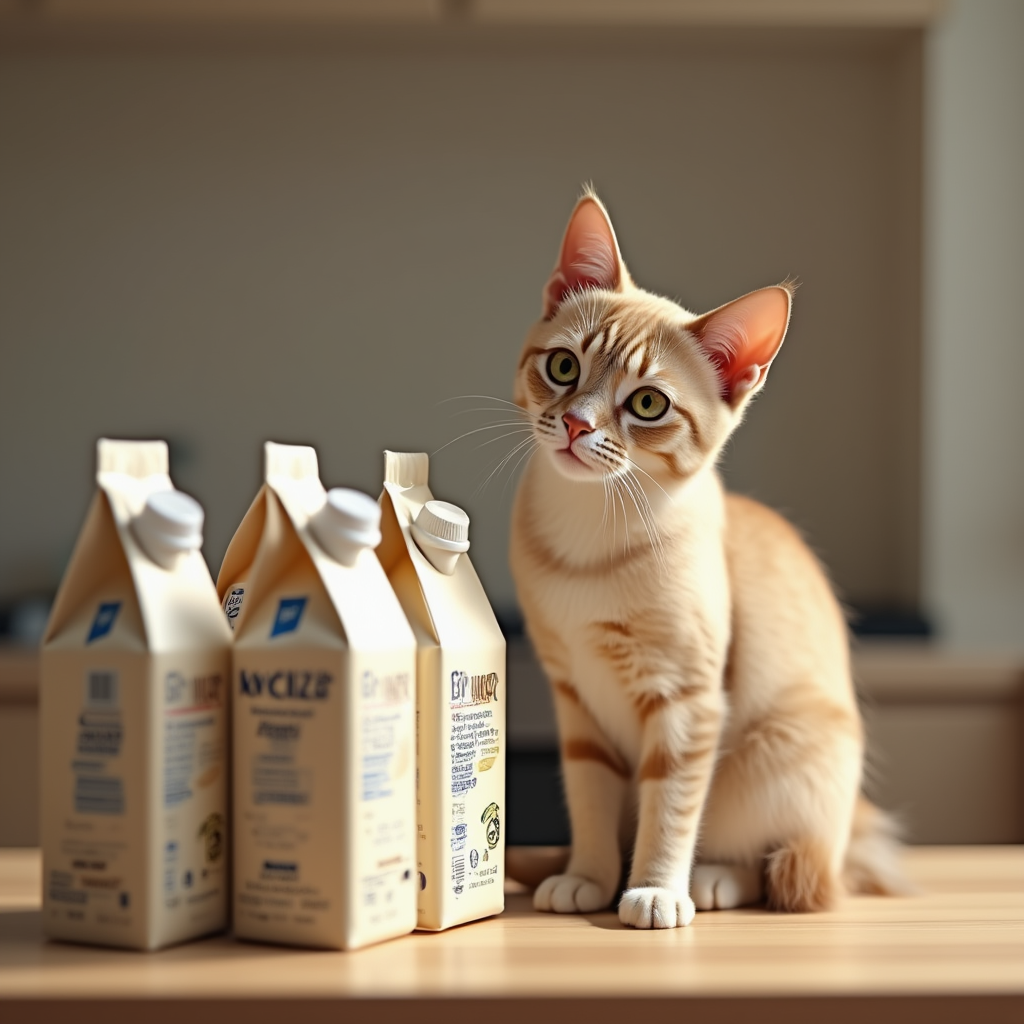

Thinking: <think>
The model should generate an image where a cat is positioned in front of several milk cartons, partially obscuring them, demonstrating occlusion.
The complete, polished prompt is: A cozy indoor scene featuring a domestic cat sitting in front of several milk cartons, partially obscuring them to create a sense of depth and occlusion. The cat is a sleek, short-haired breed with soft fur in a warm, natural color like beige or light brown, and its posture is relaxed yet alert. The milk cartons are arranged in a slightly staggered manner, with some partially hidden behind the cat, showcasing their branding and design. The setting is softly lit with warm, diffused lighting, creating a calm and inviting atmosphere. The background is minimalistic, with a neutral-toned surface like a wooden table or countertop, ensuring the focus remains on the cat and the milk cartons. The image is ultra-realistic, with fine details in the textures of the fur, the glossy finish of the cartons,

In [10]:
prompt = 'Milk cartons behind a cat'
print(prompt)
print('-' * 10)
output_dict = inferencers[1](text=prompt, **t2i_think_params)
display(output_dict['image'])
print(f"Thinking: {output_dict['text']}")